## Generate .csv files that contain design matrix of online ratings

Zizhuang Miao

This script is used to generate and store design matrices that contain online participants' ratings of social interactions and theory of mind (ToM) in the narratives. The same script can be adapted for generating design matrices from any feature of the narratives that has been matched to the time series of social interactions and ToM ratings (see `data/all_ratings_annotations`). It also checks the sanity and potential multicollinearity problem.

All design matrices are also shared in `data/all_design_matrices`.

In [ ]:
## ALWAYS RUN FIRST
import pandas as pd
import numpy as np
import os
from nltools.data import Brain_Data, Design_Matrix
from nltools.file_reader import onsets_to_dm

The code chunk below creates design matrices for theory of mind, but should be very easy to be changed into one for social interactions -- just change the variable names.

In [ ]:
eventsDir = ''    # the directory of the events files for experimenters' annotations; used to get 'rating' and fixation timing
ratingsDir = ''    # the directory of the online ratings files
outputDir = ''    # self-defined output directory
tr = 0.46
numberTr = {'1': 961, '2': 1092, '3': 1292, '4': 1150}    # number of TRs in each run

subList = pd.read_csv('./cleanedSubjects.csv')['subjects']
runDict = {'1': [7, 8], '2': [5, 6], '3': [3, 4], '4': [1, 2]}    # a mapping between run number and narrative number

for sub in subList:
    subID = int(sub[-4:])
    
    tom_mean_audio = []   # store the mean of run 1 and 2 social interaction regressors
    tom_mean_text = []  # store the mean of run 3 and 4 social interaction regressors
    n_ratings_audio = []    # valid ratings of audio runs
    n_ratings_text = []   # valid ratings of text runs
    idx_tom_all = {'1':[], '2':[], '3':[], '4':[]}    # store the indices of all fixation and rating periods

    for run in runDict.keys():
        onsetsFile = os.path.join(eventsDir, f'.csv')    # the events file for experimenters' annotations
        if not os.path.isfile(onsetsFile):
            print(f'There is no events file for {sub} run-{run}!')
            continue
        dm = onsets_to_dm(onsetsFile, sampling_freq=1/tr, run_length=numberTr[run])    # get the 'rating' column and turn that into one column in the design matrix
        fixation = ~((dm['noSocInt_text']==1) | (dm['SocInt_text']==1) | (dm['rating']==1)) if run in ['3', '4'] else ~((dm['noSocInt_audio']==1) | (dm['SocInt_audio']==1) | (dm['rating']==1))    # get a column for fixation periods
        dm = dm.drop(columns=['noSocInt_text', 'SocInt_text']) if run in ['3', '4'] else dm.drop(columns=['noSocInt_audio', 'SocInt_audio'])
        
        ## get the online ratings together with timing information
        onsets = pd.read_csv(onsetsFile)
        idx = 0    # which row of the original onsets file is being used now
        # there were two narratives in each run
        # the first narrative
        ratings = pd.read_csv(f"{ratingsDir}/narrative{runDict[run][1-subID%2]}")    # the median ratings of the first narrative
        lastTimePoint = []
        oriTiming = ratings['time']
        medians = ratings['median']
        included = ratings['included']
        for s in range(1,10):
            slices = oriTiming.loc[ratings['situation']==s]
            lastTimePoint.append(ratings.loc[ratings['situation']==s, 'time'].iloc[0])
            slices -= lastTimePoint[-1]
            if run in ['1', '2']:   # audio runs
                slices -= 0.3    # align the time = 0 with when audio began to play
            slices += onsets.loc[idx, 'Onset']
            oriTiming.loc[ratings['situation']==s] = slices
            while onsets.loc[idx, 'Stim'] != 'rating':
                idx += 1    # get the idx of the first event of the next trial
            idx += 1

        # the second narrative
        ratings = pd.read_csv(f"{ratingsDir}/narrative{runDict[run][subID%2]}")
        lastTimePoint = []
        oriTiming2 = ratings['time']
        medians2 = ratings['median']
        included2 = ratings['included']
        for s in range(1,10):
            slices = oriTiming2.loc[ratings['situation']==s]
            lastTimePoint.append(ratings.loc[ratings['situation']==s, 'time'].iloc[0])
            slices -= lastTimePoint[-1]
            if run in ['1', '2']:   # audio runs
                slices -= 0.3
            slices += onsets.loc[idx, 'Onset']
            oriTiming2.loc[ratings['situation']==s] = slices
            while onsets.loc[idx, 'Stim'] != 'rating':
                idx += 1
            idx += 1     # get the idx of the first event of the next trial

        oriTiming = pd.concat([oriTiming, oriTiming2], ignore_index=True)
        oriTiming = oriTiming.reset_index()
        oriTiming = oriTiming.drop(columns='index')
        medians = pd.concat([medians, medians2], ignore_index=True)
        medians = medians.reset_index()
        medians = medians.drop(columns='index')
        included = pd.concat([included, included2], ignore_index=True)
        included = included.reset_index()
        included = included.drop(columns='index')

        ## interpolate ratings to each TR
        # we want to add two (sets of) columns to the design matrix
        # the first is a continuous regressor for ToM
        # the second is one indicator regressor for one time point that will not be modeled (only for social interactions, ToM, and multi-person presence but not other features)
        ToM = Design_Matrix(np.zeros(dm.shape[0]), sampling_freq=1/tr)
        ToM.columns = ['ToM_text'] if run in ['3', '4'] else ['ToM_audio']

        idx = 0    # which row of the online ratings' timing has been used now
        for i in range(dm.shape[0]):
            t = i*tr
            if idx == 0:
                if t >= oriTiming.iloc[0, 0] - tr/2:   # the first viable rating is not interpolated
                    ToM.iloc[i, 0] = (medians.iloc[0, 0]*2-100)/100
                    idx += 1
            elif idx < len(oriTiming)-1:    # the intermediate ratings are linearly interpolated 
                if t >= oriTiming.iloc[idx-1, 0]:
                    while not (oriTiming.iloc[idx-1, 0] <= t and oriTiming.iloc[idx, 0] > t):
                        idx += 1
                        if idx == len(oriTiming)-1:
                            break
                    if idx < len(oriTiming):
                        ToM.iloc[i, 0] = ((medians.iloc[idx-1, 0] + (medians.iloc[idx, 0] - medians.iloc[idx-1, 0])*(t-oriTiming.iloc[idx-1, 0])/(oriTiming.iloc[idx, 0] - oriTiming.iloc[idx-1, 0]))*2-100)/100
                    else:
                        ToM.iloc[i, 0] = (medians.iloc[idx, 0]*2-100)/100    # the last rating is not interpolated
                else:
                    continue
            elif idx == len(oriTiming)-1:
                continue
        
        # put tom ratings as 0 for the rating and fixation periods
        # and mean-center tom regressors
        idx_notom = (dm['rating']==1) | (fixation==1)
        if run in ['3', '4']:
            ToM.loc[idx_notom, 'ToM_text'] = 0
        else:
            ToM.loc[(dm['rating']==1) | (fixation==1), 'ToM_audio'] = 0
        outputDm = Design_Matrix(pd.concat([dm, ToM], axis=1), sampling_freq=1/tr)

        # create spike regressors for images not included
        nDiscarded = 0    # number of discarded TRs
        TR_excluded = []
        for idx in range(included.shape[0]):
            if included.iloc[idx, 0] == 0:
                nTR = oriTiming.iloc[idx, 0]//tr
                TR_excluded.append(nTR)
        for nTR in np.unique(TR_excluded):
            exec(f'spike{nDiscarded}_run{run}=Design_Matrix(np.zeros(dm.shape[0]), sampling_freq=1/tr)')
            exec(f"spike{nDiscarded}_run{run}.columns=['spike{nDiscarded}_run{run}']")
            exec(f"spike{nDiscarded}_run{run}.iloc[{int(nTR)}, 0]=1")
            nDiscarded += 1
        idx_notexcluded = np.ones(dm.shape[0], dtype=bool)
        idx_notexcluded[np.unique(TR_excluded).astype(int)] = False   

        # put the ToM regressors to 0 for the excluded time points
        if run in ['3', '4']:
            outputDm.loc[~idx_notexcluded, 'ToM_text'] = 0
        else:
            outputDm.loc[~idx_notexcluded, 'ToM_audio'] = 0 

        # we want to calculate the mean of non-excluded time points
        if run in ['3', '4']:
            tom_mean_text.append(ToM.loc[(~idx_notom) & (idx_notexcluded), 'ToM_text'].mean())
            n_ratings_text.append(np.sum((~idx_notom) & (idx_notexcluded)))
        else:
            tom_mean_audio.append(ToM.loc[(~idx_notom) & (idx_notexcluded), 'ToM_audio'].mean())
            n_ratings_audio.append(np.sum((~idx_notom) & (idx_notexcluded)))
        idx_tom_all[run] = (~idx_notom) & (idx_notexcluded)

        for i in range(nDiscarded):
            exec(f"outputDm = Design_Matrix(pd.concat([outputDm, spike{i}_run{run}], axis=1), sampling_freq=1/tr)")
        outputDm = outputDm.fillna(0)
        outputDm.to_csv(os.path.join(outputDir, f"{sub}_run0{run}.csv"), index=False)

    # change the regressors for ToM run by run
    if len(tom_mean_audio) == 1:
        mean_audio = tom_mean_audio[0]
    elif len(tom_mean_audio) == 2:
        mean_audio = (tom_mean_audio[0] * n_ratings_audio[0] + tom_mean_audio[1] * n_ratings_audio[1]) / (n_ratings_audio[0] + n_ratings_audio[1])

    if len(tom_mean_text) == 1:
        mean_text = tom_mean_text[0]
    elif len(tom_mean_text) == 2:
        mean_text = (tom_mean_text[0] * n_ratings_text[0] + tom_mean_text[1] * n_ratings_text[1]) / (n_ratings_text[0] + n_ratings_text[1])

    for r in range(1, 5):
        if not os.path.isfile(os.path.join(outputDir, f"{sub}_run0{r}.csv")):
            continue
        outputDm = pd.read_csv(os.path.join(outputDir, f"{sub}_run0{r}.csv"))
        if r >= 3:
            outputDm.loc[idx_tom_all[str(r)], 'ToM_text'] -= mean_text
        else:
            outputDm.loc[idx_tom_all[str(r)], 'ToM_audio'] -= mean_audio
        outputDm.to_csv(os.path.join(outputDir, f"{sub}_run0{r}.csv"), index=False)

##### Sanity check

Plot and inspect the time series of regressors.

<Axes: ylabel='SInt'>

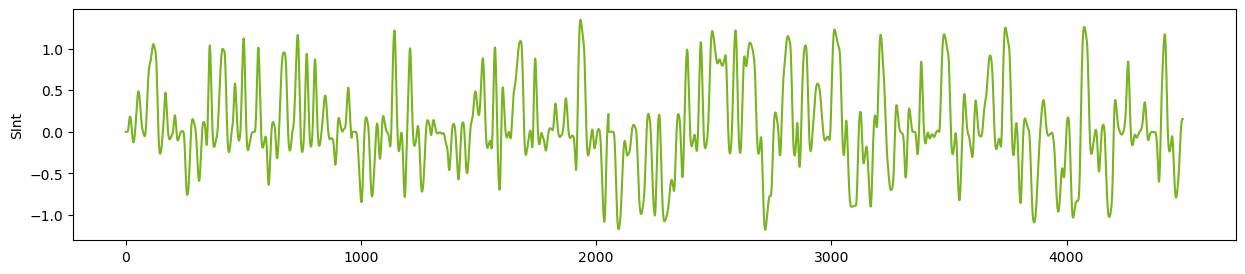

In [5]:
import pandas as pd
import numpy as np
import os
from nltools.data import Brain_Data, Design_Matrix
import seaborn as sns
import matplotlib.pyplot as plt

socEventsDir = ''

sub = 'sub-0023'
tr = 0.46
modality = ['Audio', 'Audio', 'Text', 'Text']

allDm = Design_Matrix(sampling_freq=1/tr)
for i, run in enumerate(['1', '2', '3', '4']):
    socEvents = pd.read_csv(os.path.join(socEventsDir, f"{sub}_run0{run}.csv"))
    socEvents = socEvents.rename(columns={'SInt_audio': 'SInt'}) if i <= 1 else socEvents.rename(columns={'SInt_text': 'SInt'})
    dm_soc = Design_Matrix(socEvents['SInt'], sampling_freq=1/tr)
    dm_soc = dm_soc.convolve()
    dm_soc.columns = ['SInt']
    allDm = pd.concat([allDm, dm_soc], axis=0)

allDm = allDm.reset_index(drop=True)
plt.figure(figsize=(15, 3))
sns.lineplot(data=allDm, x=allDm.index, y='SInt', color='#78B41F')

#### Check for multicollinearity with social interaction ratings

As we are going to run a GLM with both ToM and social interaction ratings as regressors, it is important to check whether that would lead to a multicollinearity problem, because the two ratings have a non-trivial correlation (~0.3). Below we investigate this potential issue.

In [1]:
from nltools.data import Design_Matrix
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
import os

# define a function to calculate VIF for each column
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

In [14]:
tomEventsDir = ''
socEventsDir = ''

subList = ['sub-0023', 'sub-0024']

nTRs = [961, 1092, 1292, 1150]
tr = 0.46

for sub in subList:
    allDm = Design_Matrix(sampling_freq = 1/tr)    # a multi-run design matrix
    for run in range(1,5):
        tomEvents = Design_Matrix(pd.read_csv(os.path.join(tomEventsDir, f"{sub}_run0{run}.csv")), sampling_freq = 1/tr)
        socEvents = Design_Matrix(pd.read_csv(os.path.join(socEventsDir, f"{sub}_run0{run}.csv")), sampling_freq = 1/tr)
        socEvents = socEvents.drop(columns=['rating'])
        # get the column names that match the pattern "spike{x}_run{y}"
        spike_columns = [col for col in tomEvents.columns if re.match(r"spike\d+_run\d+", col)]
        # the sum of the spike columns
        sums = tomEvents[spike_columns].sum(axis=1)
        columnsToDrop = []
        for i in range(1, socEvents.shape[1]):
            # check whether the row of "1" in column i of socEvents also has a "1" in the corresponding row of sums
            idx = np.where(socEvents.iloc[:, i] == 1)[0][0]
            if sums[idx] == 1:
                columnsToDrop.append(socEvents.columns[i])
        socEvents_updated = socEvents.drop(columns=columnsToDrop)
        for i in range(1, socEvents_updated.shape[1]):
            socEvents_updated = socEvents_updated.rename(columns={socEvents_updated.columns[i]: f"SocInt_{socEvents_updated.columns[i]}"})
        dm = Design_Matrix(pd.concat([tomEvents, socEvents_updated], axis=1), sampling_freq = 1/tr)
        dm = dm.reset_index(drop=True)

        allDm = allDm.append(dm, axis=0)

    allDm['ToM_audio'] = allDm['ToM_audio'] - allDm['ToM_audio'].mean()
    allDm['ToM_text'] = allDm['ToM_text'] - allDm['ToM_text'].mean()
    allDm.loc[allDm['ToM_audio']>0, 'ToM_audio'] = allDm.loc[allDm['ToM_audio']>0, 'ToM_audio'] / allDm.loc[allDm['ToM_audio']>0, 'ToM_audio'].mean()
    allDm.loc[allDm['ToM_audio']<0, 'ToM_audio'] = allDm.loc[allDm['ToM_audio']<0, 'ToM_audio'] / abs(allDm.loc[allDm['ToM_audio']<0, 'ToM_audio'].mean())
    allDm.loc[allDm['ToM_text']>0, 'ToM_text'] = allDm.loc[allDm['ToM_text']>0, 'ToM_text'] / allDm.loc[allDm['ToM_text']>0, 'ToM_text'].mean()
    allDm.loc[allDm['ToM_text']<0, 'ToM_text'] = allDm.loc[allDm['ToM_text']<0, 'ToM_text'] / abs(allDm.loc[allDm['ToM_text']<0, 'ToM_text'].mean())
    #allDm = allDm.convolve(columns=['ToM_audio', 'ToM_text', 'rating'])
    
    dm = allDm[['ToM_audio', 'ToM_text', 'SInt_audio', 'SInt_text', 'rating']]
    dmCon = allDm.convolve(columns=['ToM_audio', 'ToM_text', 'SInt_audio', 'SInt_text', 'rating'])
    dmCon = dmCon[['ToM_audio_c0', 'ToM_text_c0', 'SInt_audio_c0', 'SInt_text_c0', 'rating_c0']]
    print(f'Correlation matrix of unconvovled design matrix for {sub}:')
    print(dm.corr(), end='\n\n')
    print(f'Correlation matrix of convovled design matrix for {sub}:')
    print(dmCon.corr())

Correlation matrix of unconvovled design matrix for sub-0023:
            ToM_audio  ToM_text  SInt_audio  SInt_text    rating
ToM_audio    1.000000 -0.072913    0.367644  -0.011743 -0.220050
ToM_text    -0.072913  1.000000   -0.034567   0.286182 -0.137314
SInt_audio   0.367644 -0.034567    1.000000  -0.005567 -0.104321
SInt_text   -0.011743  0.286182   -0.005567   1.000000 -0.022116
rating      -0.220050 -0.137314   -0.104321  -0.022116  1.000000

Correlation matrix of convovled design matrix for sub-0023:
               ToM_audio_c0  ToM_text_c0  SInt_audio_c0  SInt_text_c0  \
ToM_audio_c0       1.000000    -0.065059       0.382536     -0.010402   
ToM_text_c0       -0.065059     1.000000      -0.030248      0.292995   
SInt_audio_c0      0.382536    -0.030248       1.000000     -0.004713   
SInt_text_c0      -0.010402     0.292995      -0.004713      1.000000   
rating_c0         -0.245131    -0.135916      -0.075094     -0.001017   

               rating_c0  
ToM_audio_c0   -0.245

In [7]:
print('The VIF values of the original design matrix are as follows:')
print(calculate_vif(dmCon))

The VIF values of the original design matrix are as follows:
       Variable       VIF
0     ToM_audio  1.279272
1      ToM_text  1.083669
2  SocInt_audio  1.276910
3   SocInt_text  1.082408
4        rating  1.005421


In [9]:
vifs = calculate_vif(allDm)

In [10]:
print(vifs.sort_values(by='VIF', ascending=False))

         Variable       VIF
18      ToM_audio  1.400287
0      SInt_audio  1.326625
19       ToM_text  1.165418
1       SInt_text  1.114385
186  spike47_run2  1.010069
..            ...       ...
50   spike16_run2  1.000000
201  spike50_run1  1.000000
77   spike22_run1  1.000000
37   spike13_run1  1.000000
38   spike13_run2  1.000000

[261 rows x 2 columns]
